In [ ]:
import os
import numpy as np
from PIL import Image

# Veri seti yolu
data_path ="/content/drive/MyDrive/malaria/cell_images/cell_images"

# Sınıf etiketleri
class_names =  ["Parasitized", "Uninfected"]

# Veri setindeki görüntü sayısı
num_samples = sum([len(files) for r, d, files in os.walk(data_path)])

# Veri seti boyutları
img_height, img_width = 64, 64
num_channels = 3

# X ve y için numpy dizileri
X = np.zeros((num_samples, img_height, img_width, num_channels), dtype=np.float32)
y = np.zeros((num_samples,), dtype=np.int32)

# Verileri yükleyip numpy dizilerine dönüştürme
index = 0
for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        img = img.resize((img_height, img_width))
        X[index] = np.array(img, dtype=np.float32) / 255.
        y[index] = i
        index += 1

# Veri setini karıştırma
np.random.seed(42)
shuffle_index = np.random.permutation(num_samples)
X, y = X[shuffle_index], y[shuffle_index]

# Veri setini train, test ve validation olarak ayırma
num_train_samples = int(0.7 * num_samples)
num_test_samples = int(0.2 * num_samples)
num_val_samples = num_samples - num_train_samples - num_test_samples

x_train, y_train = X[:num_train_samples], y[:num_train_samples]
x_test, y_test = X[num_train_samples:num_train_samples+num_test_samples], y[num_train_samples:num_train_samples+num_test_samples]
x_val, y_val = X[num_train_samples+num_test_samples:], y[num_train_samples+num_test_samples:]

# Dizileri npy dosyalarına kaydetme
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dropout, Flatten, Dense, Reshape
from sklearn.preprocessing import StandardScaler

In [ ]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [ ]:
# Train verilerinin normalizasyonu
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std

# Test verilerinin normalizasyonu
x_test = (x_test - mean) / std

# Validation verilerinin normalizasyonu
x_val = (x_val - mean) / std


In [ ]:
# Model oluşturma
model = Sequential()

# Convolutional layerlar
model.add(Conv2D(32, (3,3), activation='relu', input_shape=x_train[0].shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# LSTM layer
model.add(Reshape((-1, 128)))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())

# Fully connected layerlar
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model eğitimi
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/100
603/603 [==============================] - 5s 9ms/step - loss: 0.1413 - accuracy: 0.9556 - val_loss: 0.1428 - val_accuracy: 0.9554
Epoch 2/100
603/603 [==============================] - 6s 11ms/step - loss: 0.1345 - accuracy: 0.9560 - val_loss: 0.1388 - val_accuracy: 0.9543
Epoch 3/100
603/603 [==============================] - 5s 9ms/step - loss: 0.1259 - accuracy: 0.9583 - val_loss: 0.1233 - val_accuracy: 0.9583
Epoch 4/100
603/603 [==============================] - 6s 10ms/step - loss: 0.1205 - accuracy: 0.9592 - val_loss: 0.1288 - val_accuracy: 0.9547
Epoch 5/100
603/603 [==============================] - 5s 9ms/step - loss: 0.1114 - accuracy: 0.9617 - val_loss: 0.1362 - val_accuracy: 0.9583
Epoch 6/100
603/603 [==============================] - 6s 10ms/step - loss: 0.1076 - accuracy: 0.9621 - val_loss: 0.1207 - val_accuracy: 0.9579
Epoch 7/100
603/603 [==============================] - 8s 13ms/step - loss: 0.0995 - accuracy: 0.9644 - val_loss: 0.1220 - val_accuracy: 0.

In [ ]:
# Test verisi üzerinde değerlendirme
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

173/173 [==============================] - 1s 5ms/step - loss: 0.3116 - accuracy: 0.9574
Test loss: 0.3115592896938324
Test accuracy: 0.9573580026626587


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
print(val_acc)

[0.9556246995925903, 0.9560393691062927, 0.9583203792572021, 0.9592016339302063, 0.9616900086402893, 0.9621047377586365, 0.9644375443458557, 0.9672369360923767, 0.9696215391159058, 0.9727320075035095, 0.9750129580497742, 0.9779160022735596, 0.9815967082977295, 0.9847071170806885, 0.988024890422821, 0.989217221736908, 0.9903576970100403, 0.9903058409690857, 0.9910834431648254, 0.9920684099197388, 0.9943494200706482, 0.9924831390380859, 0.994401216506958, 0.9947641491889954, 0.9944530725479126, 0.9947641491889954, 0.9966303706169128, 0.994245707988739, 0.9951270222663879, 0.9948678016662598, 0.9971487522125244, 0.9965785145759583, 0.9959564805030823, 0.9962674975395203, 0.994971513748169, 0.9970969557762146, 0.9947122931480408, 0.9975116848945618, 0.9966822266578674, 0.9966822266578674, 0.9968377351760864, 0.9966822266578674, 0.9977708458900452, 0.996734082698822, 0.9981337189674377, 0.9958527684211731, 0.9977190494537354, 0.9978227019309998, 0.9964230060577393, 0.99704509973526, 0.99787

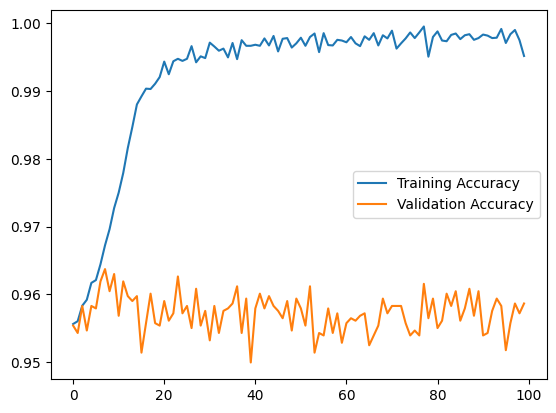

In [ ]:
import matplotlib.pyplot as plt

# Accuracy değerleri
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Eğitim ve doğrulama Accuracy değerlerini grafik olarak çizdirme
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

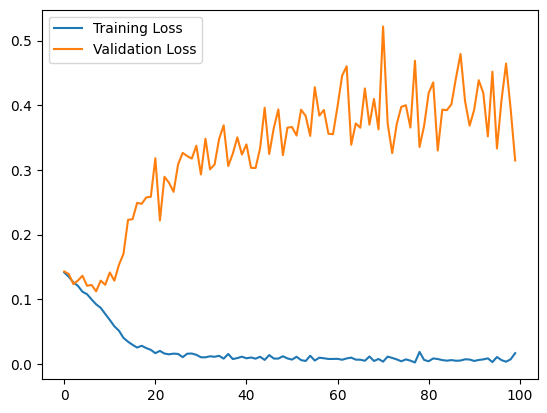

In [ ]:
# Loss değerleri
loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim ve doğrulama Loss değerlerini grafik olarak çizdirme
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()